### Looping Agent

In [40]:
from typing import TypedDict, List, Literal
import random
from langgraph.graph import StateGraph, START, END
import nest_asyncio
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod
nest_asyncio.apply()

def show_graph(app):
    display(Image(app.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.PYPPETEER)))

In [41]:
class AgentState(TypedDict):
    name: str
    number: List[int]
    counter: int # for loop counter

In [42]:
def greet(state: AgentState) -> AgentState:
    """Greet the Person using this node"""
    state['name'] = f"Hi {state['name']}"
    state['counter'] = 0
    return state

def random_node(state: AgentState) -> AgentState:
    """Generate and add a random number (between 0 to 10) to the  numbers list"""
    state['number'].append(random.randint(0,10))
    state['counter'] += 1
    return state

def should_continue(state: AgentState) -> AgentState:
    """ Decider function """
    if state['counter'] < 5:
        print("ENTERING LOOP", state['counter'])
        return "loop"
    else:
        print("TAKING THE EXIT EDGE", state['counter'])
        return "exit"

In [43]:
graph = StateGraph(AgentState)

graph.add_node("greet_node",greet)
graph.add_node("random_node",random_node)

graph.add_edge(START, "greet_node")
graph.add_edge("greet_node","random_node")
graph.add_conditional_edges(
    "random_node",
    should_continue,
    {
        "loop": "random_node", # loop back to same node
        "exit": END
    }
)

app = graph.compile()

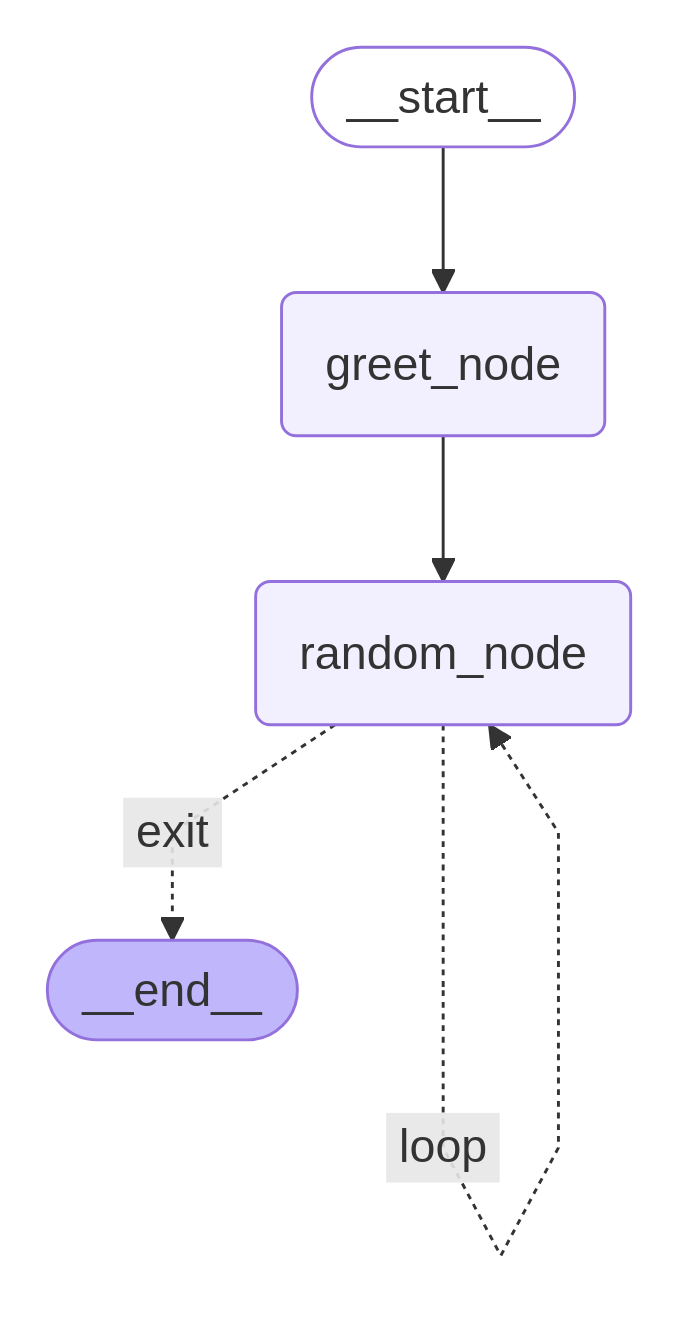

In [44]:
show_graph(app)

In [45]:
app.invoke(AgentState(name="Charlie", number=[], counter=-1))

ENTERING LOOP 1
ENTERING LOOP 2
ENTERING LOOP 3
ENTERING LOOP 4
TAKING THE EXIT EDGE 5


{'name': 'Hi Charlie', 'number': [4, 0, 6, 6, 2], 'counter': 5}

#### Automatic Guesser Graph - Exercise 5 

In [46]:
class ASE5(TypedDict):
    player_name: str
    value: int
    hint: str
    guesses: List[int]
    attempts: int
    lower_bound: int
    upper_bound: int

In [99]:
def setup(state: ASE5) -> ASE5:
    """
    Setup initial values
    """
    state['guesses'] = []
    state['hint'] = ""
    state['value'] = random.randint(state['lower_bound'], state['upper_bound']+1) # the true value
    state['attempts'] = 0
    return state

def guess(state: ASE5) -> ASE5:
    """
    check if the hint is none, if it is generate a random guess, 
    else generate a number according to hint and update state
    """
    state['attempts'] += 1
    if state['hint'] != "":
        latestGuess = state['guesses'][-1]
        hint = state['hint'].strip().lower()
        if hint == "lower":
            print(f"Looks like {latestGuess} was higher")
            print(f"I got to know that the number is between {state['lower_bound']} and {latestGuess}")
            # we get to know that the number is between lower_bound and latestGuess
            state['guesses'].append(random.randint(state['lower_bound'], latestGuess))
            # update upper bound
            state['upper_bound'] = latestGuess
        elif hint == "higher":
            print(f"Looks like {latestGuess} was lower")
            print(f"I got to know that the number is between {latestGuess} and {state['upper_bound']}")
            # we get to know that the number is between latestGuess and upper_bound
            state['guesses'].append(random.randint(latestGuess, state['upper_bound']))
            # update upper bound
            state['lower_bound'] = latestGuess
    else:
        # first turn, generate a random guess between the given bounds
        g = random.randint(state['lower_bound'], state['upper_bound'])
        print(f"THIS IS MY FIRST ATTEMPT, I AM GUESSING BLINDLY {g}")
        state['guesses'].append(g)
    return state

def hint(state: ASE5) -> ASE5:
    """
    check if latest guess is lower or higher that the actual value
    if latestGuess is higher, then say the actual value is "lower" and vice versa
    """
    latestGuess = state['guesses'][-1]
    if state['value'] < latestGuess:
        state['hint'] = 'lower'
    elif state['value'] > latestGuess:
        state['hint'] = 'higher'
    else:
        print(f"Yes! {latestGuess} is correct! Exiting!")
        state['hint'] = 'correct'
    
    return state
        
def should_continue(state: ASE5) -> ASE5:
    """
    check the hint and decide whether to continue the loop or not, if attempts is 7, exit
    """
    # Exit after 7 attempts (0-indexed so 6)
    if state['attempts'] == 7:
        return "exit"
    
    if state['hint'].strip().lower() == 'correct':
        return "exit"
    else:
        return "continue"

In [100]:
graph = StateGraph(ASE5)
graph.add_node("setup", setup)
graph.add_node("guess", guess)
graph.add_node("hint", hint)

graph.add_edge(START, "setup")
graph.add_edge("setup","guess")
graph.add_edge("guess","hint")
graph.add_conditional_edges(
    "hint",
    should_continue,
    {
        "continue": "guess",
        "exit": END
    }
)

app = graph.compile()

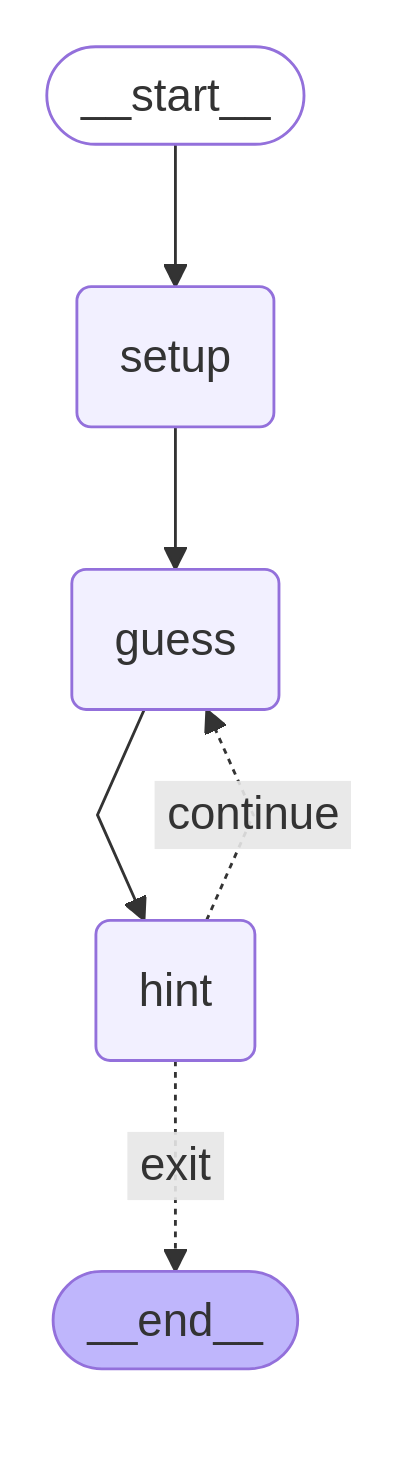

In [101]:
show_graph(app)

In [103]:
initial_state_1 = ASE5(
    player_name="student", 
    guesses=[],
    attempts=0,
    lower_bound=1,
    upper_bound=20
)
app.invoke(initial_state_1)

THIS IS MY FIRST ATTEMPT, I AM GUESSING BLINDLY 9
Yes! 9 is correct! Exiting!


{'player_name': 'student',
 'value': 9,
 'hint': 'correct',
 'guesses': [9],
 'attempts': 1,
 'lower_bound': 1,
 'upper_bound': 20}